### This revision has been adapted to work with Tensorflow 2, remember to install tensorflow_probability as it has been moved from the main code to it's own package (pip install tensorflow_probability)

MDN Hands On Tutorial

This notebook demonstrates the construction of a simple MDN, and compares it to a regular neural network.

Read about MDNs on the [original paper](https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) by C. Bishop.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input

Using TensorFlow backend.


The network we'll construct will try to learn the following relation between $x$ and $f(x)$: 

$$f(x) = x^2-6x+9$$


Note that this simply $y = x^2$ shifted three steps to the left (global minimum is at $x=3$).

In [3]:
def f(x):
    return x**2-6*x+9 

In order to make the data a little bit more realistic, we'll add a normally-distributed noise, which will be location-dependent - the larger $x$ is, the larger the noisier the data will be. So, our data generator will obey the following relation:

$$g(x) = f(x) + \epsilon(x) $$ 

$$ \text{where}: \epsilon(x) = N(0,\sigma_0 x)$$

Where $N(\mu,\sigma)$ is the normal distribution with mean $\mu$ and STD of $\sigma$.

The `data_generator` below function creates $n$ nosiy data samples for a given `x`, where $n$ is defined by `samples`. Notice that technically, `data_generator` yields $g(x) = N(f(x),\sigma_0 x)$, as mathematically that's the same thing. 

In [4]:
def data_generator(x,sigma_0,samples):
    return np.random.normal(f(x),sigma_0*x,samples)

We'll now generate our dataset for $1<x<5$.

The purple line in the plot presents the "clean" function $f(x)$ for this range.

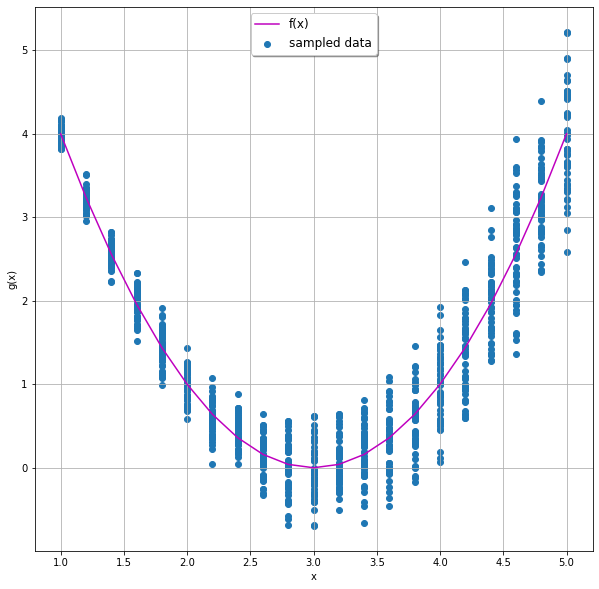

In [5]:
sigma_0 = 0.1
x_vals = np.arange(1,5.2,0.2)
x_arr = np.array([])
y_arr = np.array([])
samples = 50
for x in x_vals:
    x_arr = np.append(x_arr, np.full(samples,x))
    y_arr = np.append(y_arr, data_generator(x,sigma_0,samples))
x_arr, y_arr = shuffle(x_arr, y_arr)
x_test = np.arange(1.1,5.1,0.2)

fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('g(x)')
ax.scatter(x_arr,y_arr,label='sampled data')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

## Regular neural network
We'll now train a neural network which will receive $x$ as input and our noisy $g(x)$ but will have to learn the relation $x \rightarrow f(x)$.

The network is constructed of two hidden layers, each with 12 nodes and the $\tanh(x)$ activation function (note we use a linear activation on the last output layer which is the same as no activation function at all, since keras defaults to sigmoid if none is given for Dense layers).

We set the learning rate $\alpha=0.0003$, 50 examples per mini-batch and a total of 500 epoches.

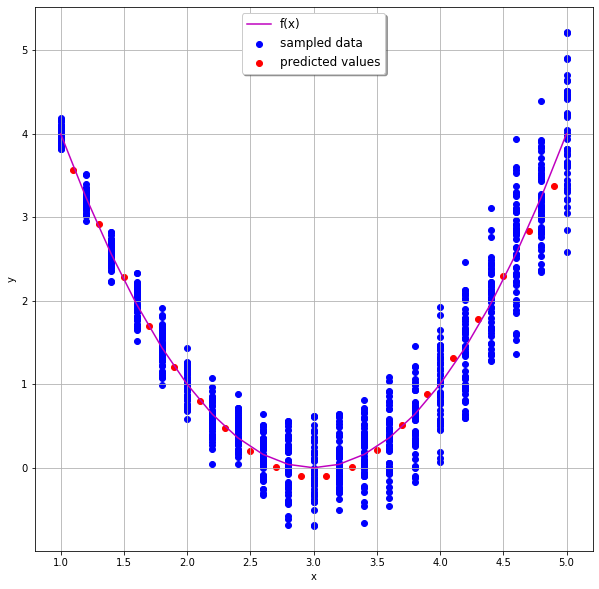

Final cost: 0.1262


In [6]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
model = Sequential()
model.add(Dense(12,input_shape=(1,),activation="tanh"))
model.add(Dense(12,activation="tanh"))
model.add(Dense(1,activation="linear"))
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='mse',optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit(x_arr,
                          y_arr,
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
y_pred = model.predict(x_test)
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(x_arr,y_arr,c='b',label='sampled data')
ax.scatter(x_test,y_pred,c='r',label='predicted values')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()
print('Final cost: {0:.4f}'.format(history_cache.history['mse'][-1]))

It seems to be doing quite good in predicting $f(x)$, but we can clearly see that the network learnt nothing about the size of the noise. 

## Mixture density network (MDN)
Let's try an MDN now. We'll use the same network as in the previous section, with one important change:
the output layer now has two nodes (which are constructed as two layers of 1 node for technical simplicity), which we named `mu` and `sigma`

Note the new cost function: we create a normal distribution out of the predicted `mu` and `sigma`, and then minimize the negative log-likelihood of this distribution yielding the target value `y`. Mathematically, our cost function is the negative logarithm of the normal distribution's probability density function (PDF):

$$Cost = -\log (PDF) = -\log\left(\frac{1}{\sqrt{2\pi}\sigma}\cdot\exp{\left[-\frac{(y-\mu)^{2}}{2\sigma^{2}}\right]}\right)$$

In [7]:
def mdn_cost(mu, sigma, y):
    dist = tfp.distributions.Normal(loc=mu, scale=sigma)
    return tf.compat.v1.reduce_mean(-dist.log_prob(y))


We'll use `elu + 1` as the activation function for `sigma`, as it must always be non-negative. The Exponential Linear Unit (ELU) is defined as:

$$ ELU(x) = \begin{cases} x & x\ge0 \\ \exp{(x)}-1 & x < 0 \end{cases} $$

Final cost: 0.1639


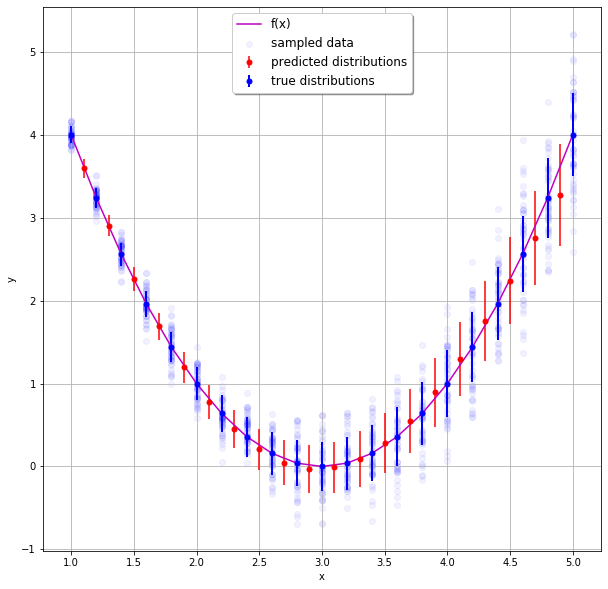

In [9]:
epochs = 500
batch_size = 50
learning_rate = 0.0003
InputLayer = Input(shape=(1,))
Layer_1 = Dense(12,activation="tanh")(InputLayer)
Layer_2 = Dense(12,activation="tanh")(Layer_1)
mu = Dense(1, activation="linear")(Layer_2)
sigma = Dense(1, activation=lambda x: tf.nn.elu(x) + 1)(Layer_2)
y_real = Input(shape=(1,))
lossF = mdn_cost(mu,sigma,y_real)
model=Model(inputs=[InputLayer, y_real], outputs=[mu, sigma])
model.add_loss(lossF)
adamOptimizer = optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=adamOptimizer,metrics=['mse'])
history_cache = model.fit([x_arr, y_arr], #notice we are using an input to pass the real values due to the inner workings of keras
                          verbose=0, # write =1 if you wish to see the progress for each epoch
                          epochs=epochs,
                          batch_size=batch_size)
print('Final cost: {0:.4f}'.format(history_cache.history['loss'][-1]))
mu_pred, sigma_pred = model.predict(list((x_test,x_test))) # the model expects a list of arrays as it has 2 inputs
fig, ax = plt.subplots(figsize=(10,10))
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
ax.errorbar(x_test,mu_pred,yerr=np.absolute(sigma_pred),c='r',ls='None',marker='.',ms=10,label='predicted distributions')
ax.scatter(x_arr,y_arr,c='b',alpha=0.05,label='sampled data')
ax.errorbar(x_vals,list(map(f,x_vals)),yerr=list(map(lambda x: sigma_0*x,x_vals)),c='b',lw=2,ls='None',marker='.',ms=10,label='true distributions')
ax.plot(x_vals,list(map(f,x_vals)),c='m',label='f(x)')
ax.legend(loc='upper center',fontsize='large',shadow=True)
plt.show()

The plot above shows the results learnt by the network. In red are the networks predictions for 𝜇
and 𝜎, and in blue are the actual 𝜇 and 𝜎 used for the training set. The actual data can be seen faded in the background. We can clearly see the network has learnt not just 𝑥→𝑓(𝑥), but also the noise creating 𝑥→𝑔(𝑥).